In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition


In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Датасет взят такой же как в первой части лабы по классификации про мобильные телефоны**

In [ ]:
dtf = pd.read_excel('/content/train.xlsx')
dtf.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [ ]:
# Определяет, является ли столбец числовым или категориальным.
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

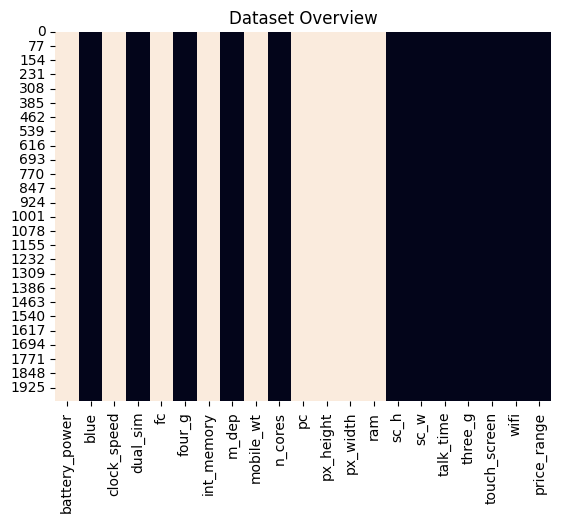

 Categerocial   Numeric   NaN 


In [ ]:
'''
формируем словарь dic_cols.
Ключи - название фич
Значение - категориальный (cat) или числовой (num)
'''
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}

heatmap = dtf.isnull()

for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [ ]:
dic_cols

{'battery_power': 'num',
 'blue': 'cat',
 'clock_speed': 'num',
 'dual_sim': 'cat',
 'fc': 'num',
 'four_g': 'cat',
 'int_memory': 'num',
 'm_dep': 'cat',
 'mobile_wt': 'num',
 'n_cores': 'cat',
 'pc': 'num',
 'px_height': 'num',
 'px_width': 'num',
 'ram': 'num',
 'sc_h': 'cat',
 'sc_w': 'cat',
 'talk_time': 'cat',
 'three_g': 'cat',
 'touch_screen': 'cat',
 'wifi': 'cat',
 'price_range': 'cat'}

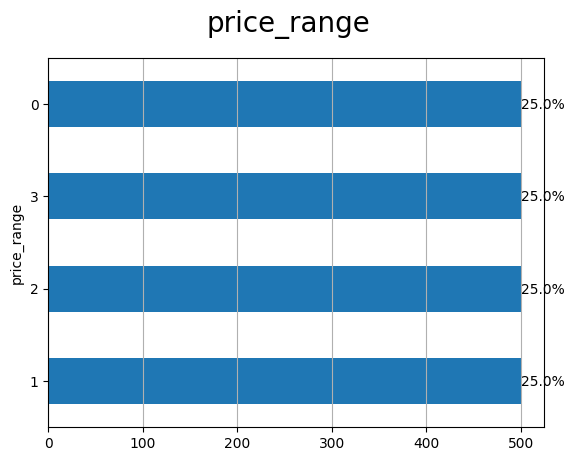

In [ ]:
#группируем все объекты по их целевой переменной и просто считаем, сколько объектов попало в каждую группу
y ="price_range"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")

# формируем надписи для графика
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

<ipython-input-21-f742696dcaa5>:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])#зададим данные для графика
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


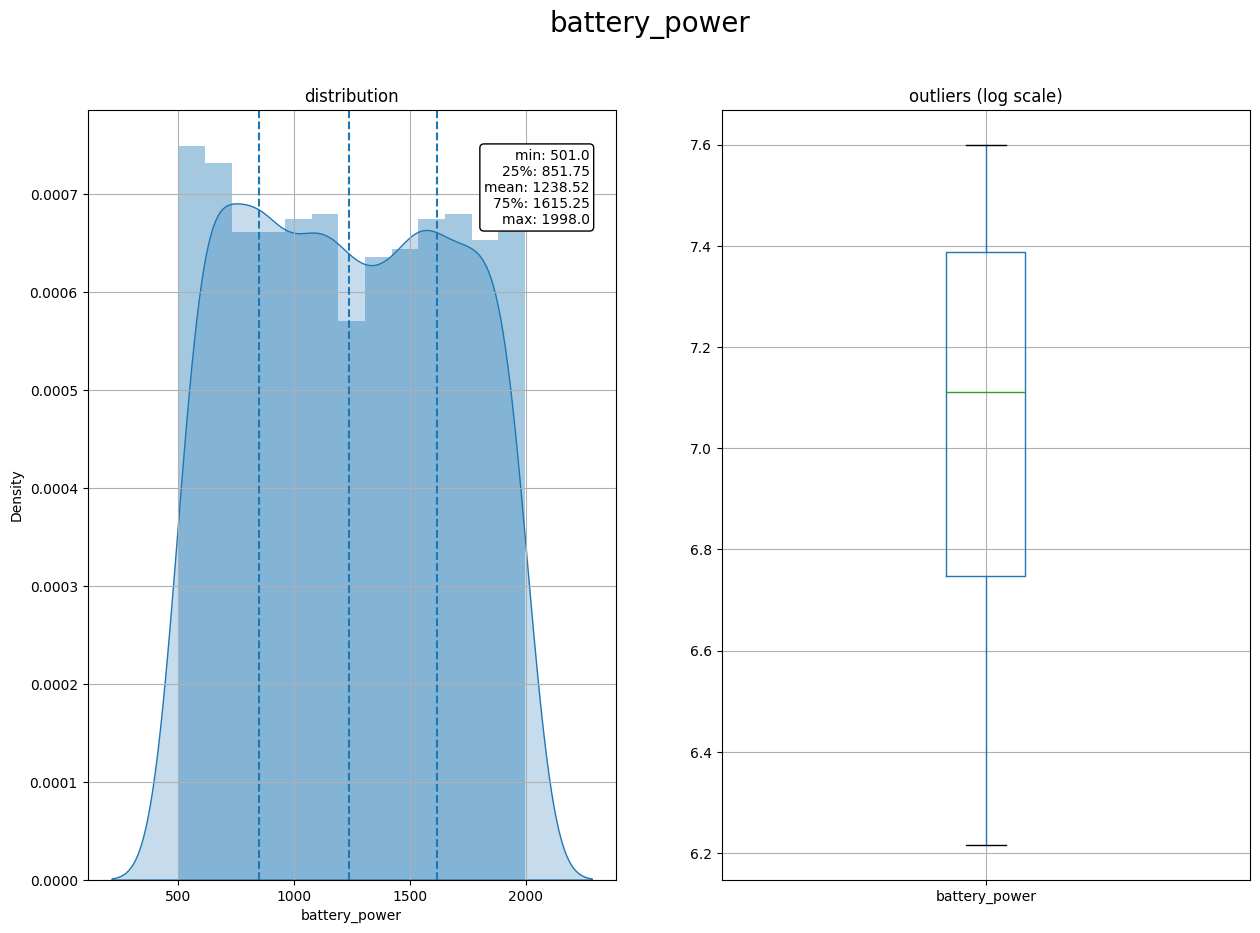

In [ ]:
# Используем блочную диаграмму для графического отображения групп данных через их квартили.
x = "battery_power"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(15, 10))
fig.suptitle(x, fontsize=20)#задаем заголовок основного рисунка

### distribution
ax[0].title.set_text('distribution') # задаем название
variable = dtf[x].fillna(dtf[x].mean()) # замена отсутствующих значений в датафрейме на средние
breaks = np.quantile(variable, q=np.linspace(0, 1, 11)) # вычисляем q-й квантиль заданных данных вдоль указанной оси.
variable = variable[ (variable > breaks[0]) & (variable <
                                               breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0]) # зададим данные для графика
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot
ax[1].title.set_text('outliers (log scale)') # устанавливаем заголовок
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

In [ ]:
def show_dist(x, dtf):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 10))
    fig.suptitle(x, fontsize=20)
    ### distribution
    ax[0].title.set_text('distribution')
    variable = dtf[x].fillna(dtf[x].mean())
    breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
    variable = variable[(variable > breaks[0]) & (variable <
                                                  breaks[10])]
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
                 ax=ax[0])  #Запишем чтобы создать горизонтальную гистограмму
    des = dtf[x].describe()

    # Добавим квантильные и средние линии
    ax[0].axvline(des["25%"], ls='--')
    ax[0].axvline(des["mean"], ls='--')
    ax[0].axvline(des["75%"], ls='--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(
        ("min: " + des["min"], "25%: " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " + des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right",
               bbox=dict(boxstyle='round', facecolor='white', alpha=1))
    ### boxplot
    ax[1].title.set_text('outliers (log scale)')  #устанавливаем заголовок
    tmp_dtf = pd.DataFrame(dtf[x])
    tmp_dtf[x] = np.log(tmp_dtf[x])
    tmp_dtf.boxplot(column=x, ax=ax[1])

    plt.show()

<ipython-input-18-6dfe14b143ec>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


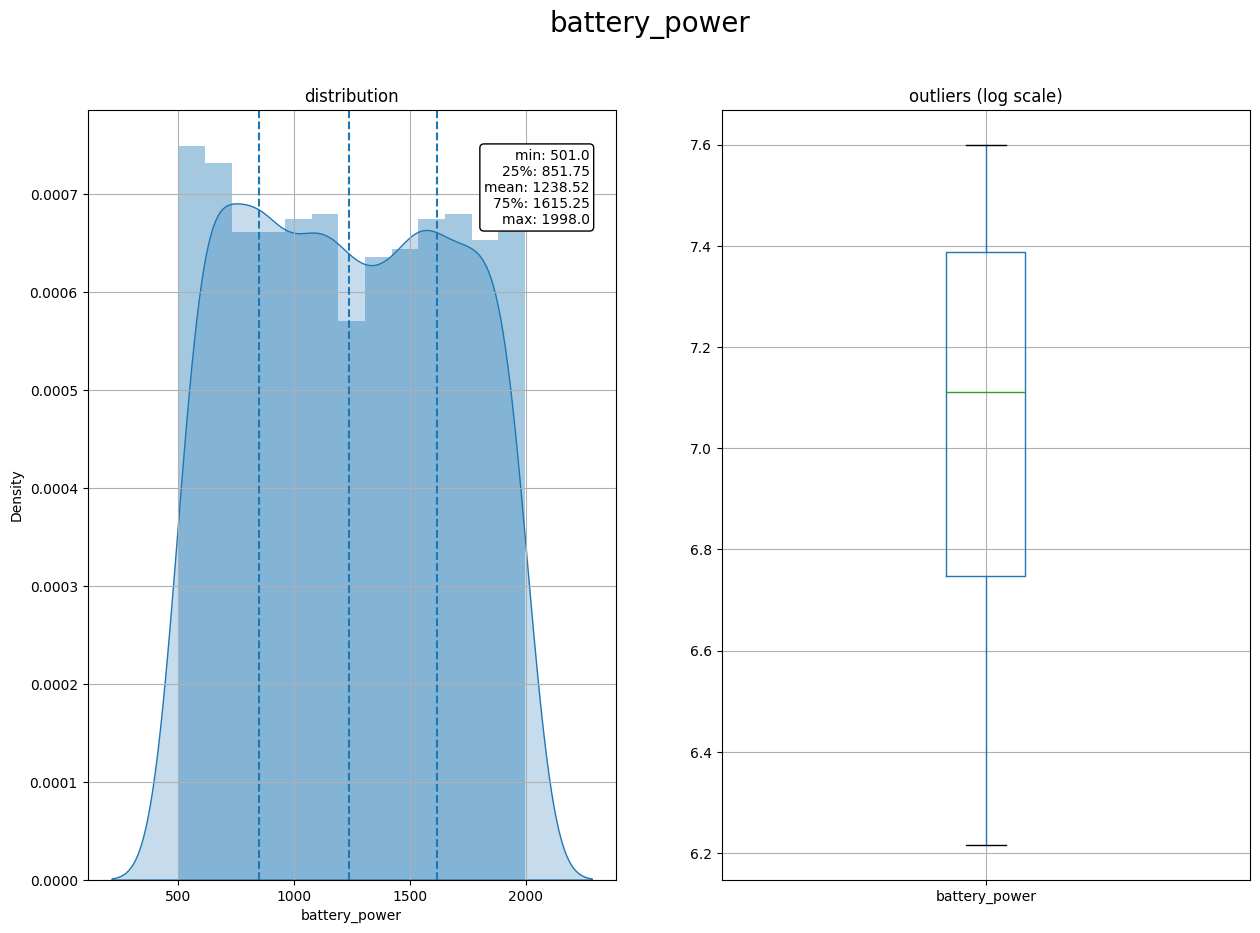

<ipython-input-18-6dfe14b143ec>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/lib/fu

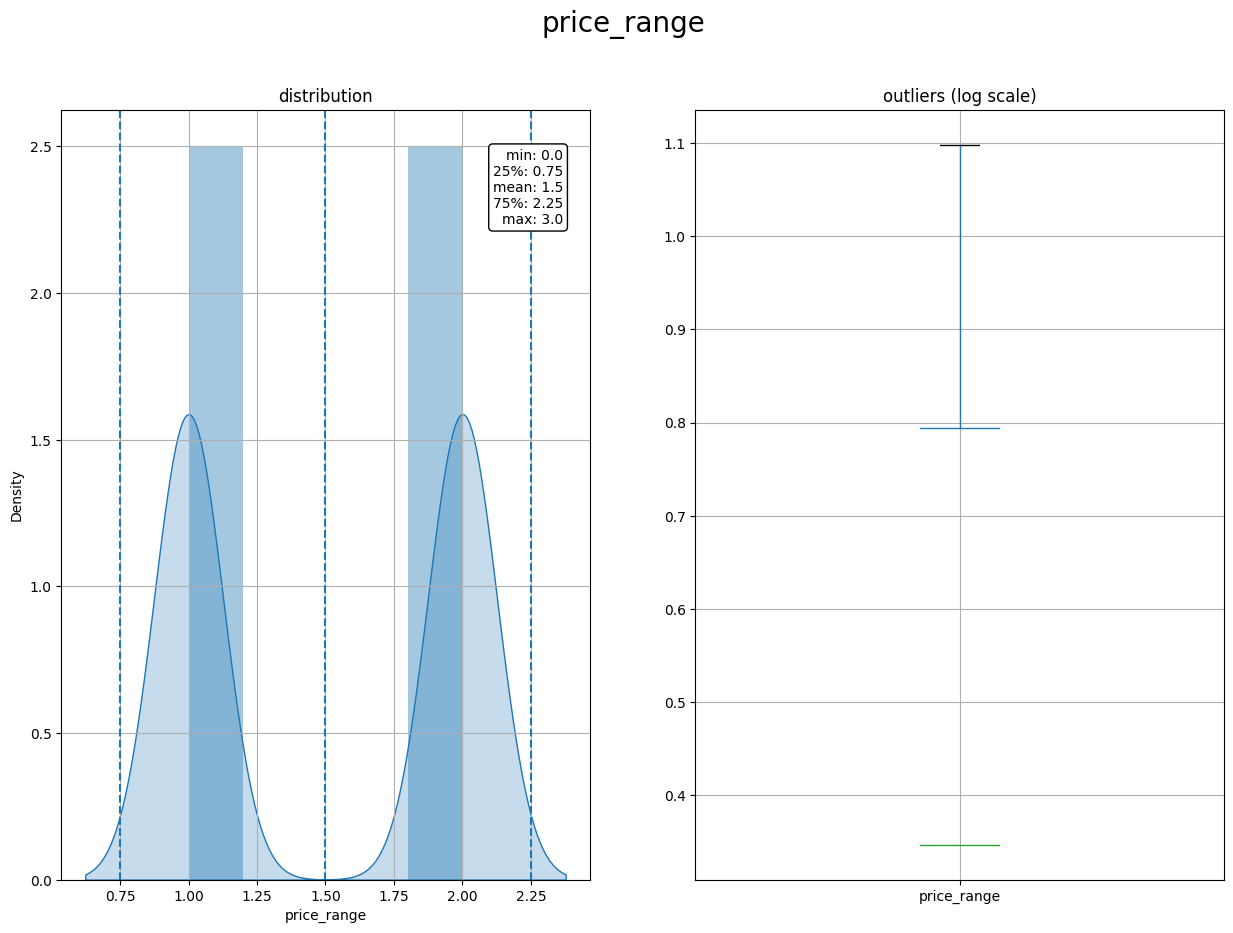

In [ ]:
show_dist('battery_power', dtf)
show_dist('price_range', dtf)

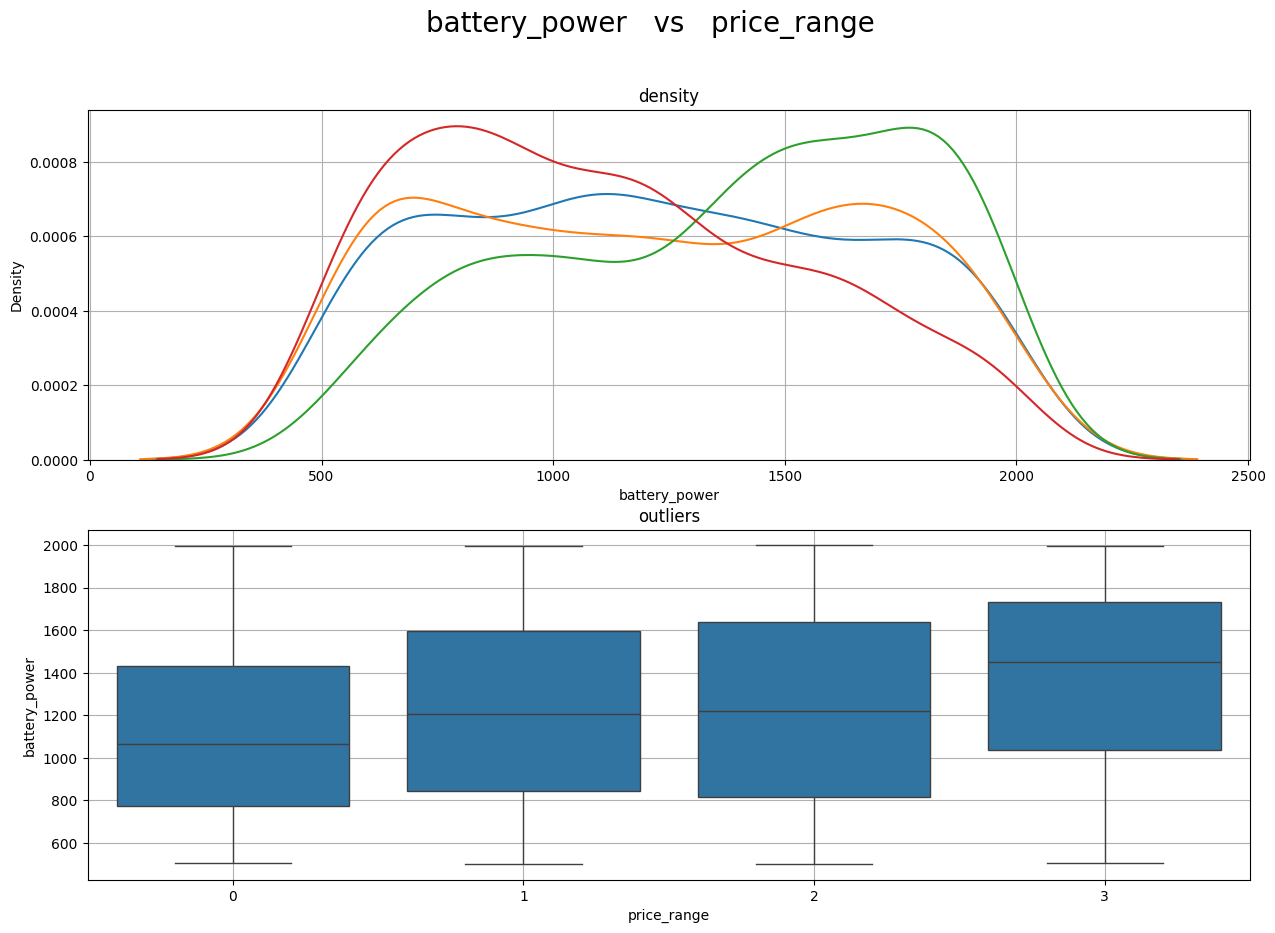

In [ ]:
cat, num = "price_range", "battery_power"
fig, ax = plt.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10))# распаковываем  кортеж в переменные figи ax.
fig.suptitle(x+"   vs   "+y, fontsize=20)# получаем объект рисунка и массив подграфиков,где первое число - количество строк,второе - столбцов, sharex, sharey задают нужно ли разделять ось между подграфиками

### distribution
ax[0].title.set_text('density')
for i in dtf[cat].unique():  # перебираем все уникальные значения в столбце dtf[cat], cat="species"
    sns.kdeplot(dtf[dtf[cat]==i][num],   label=i, ax=ax[0])#Построим график плотности распределения в столбце num, при условии, что значение в столбце dtf[cat] совпадет с i
ax[0].grid(True)#Настроим линии сетки.

### boxplot
ax[1].title.set_text('outliers')#устанавливаем заголовок
sns.boxplot(x=cat, y=num, data=dtf, ax=ax[1])#Нарисуем блочную диаграмму, чтобы показать распределения по категориям.

ax[1].grid(True)#Настроим линии сетки.
plt.show()

In [ ]:
## split data , 70% - тренировочная выборка, 30% тестовая выборка
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)

## print info
print("X_train shape:", dtf_train.drop("price_range",axis=1).shape, "| X_test shape:", dtf_test.drop("price_range",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["price_range"]),2), "| y_test mean:", round(np.mean(dtf_test["price_range"]),2))
print(dtf_train.drop("price_range",axis=1).shape[1], "features:", dtf_train.drop("price_range",axis=1).columns.to_list())

X_train shape: (1400, 20) | X_test shape: (600, 20)
y_train mean: 1.51 | y_test mean: 1.47
20 features: ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']


In [ ]:
# смотрим размер полученной выборки трейне.. 233 столбцов, 10 строк
dtf_train.shape

(1400, 21)

In [ ]:
# формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и series с целевой переменной. Для трейна
train_x = dtf_train.drop('price_range', axis=1)
train_y = dtf_train['price_range']
# формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и series с целевой переменной. Для трейна
test_x = dtf_test.drop('price_range', axis=1)
test_y = dtf_test['price_range']

In [ ]:
# нормируем значения
Y = 'price_range'
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))#приведем Числовые переменные (Numeric Variable) к диапазону от 0 до 1.
X = scaler.fit_transform(train_x)#преобразуем данные таким образом, что их распределение будет иметь среднее значение 0 и стандартное отклонение 1.
train_x_scaled = pd.DataFrame(X, columns=train_x.columns,index=train_x.index )
train_y_scaled = train_y

train_x_scaled.head()# выводим

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
773,0.841015,0.0,0.56,0.0,0.052632,1.0,0.774194,0.777778,0.983333,0.000000,0.10,0.140072,0.804275,0.612567,0.357143,0.444444,0.111111,1.0,1.0,0.0
333,0.816299,1.0,0.20,0.0,0.052632,1.0,0.080645,0.555556,0.383333,0.285714,0.85,0.197024,0.575150,0.255348,0.000000,0.000000,0.777778,1.0,1.0,1.0
380,0.917168,1.0,0.88,1.0,0.526316,0.0,0.096774,0.888889,0.716667,0.857143,0.65,0.494613,0.489646,0.264171,0.214286,0.055556,0.000000,0.0,0.0,1.0
401,0.361389,0.0,0.88,1.0,0.842105,1.0,0.774194,0.777778,0.108333,0.857143,0.90,0.373012,0.804943,0.790642,0.928571,0.000000,1.000000,1.0,1.0,1.0
167,0.417502,1.0,0.76,0.0,0.105263,1.0,0.129032,0.333333,0.666667,0.714286,0.15,0.627501,0.742151,0.479144,0.142857,0.333333,0.555556,1.0,1.0,1.0


<ipython-input-18-6dfe14b143ec>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


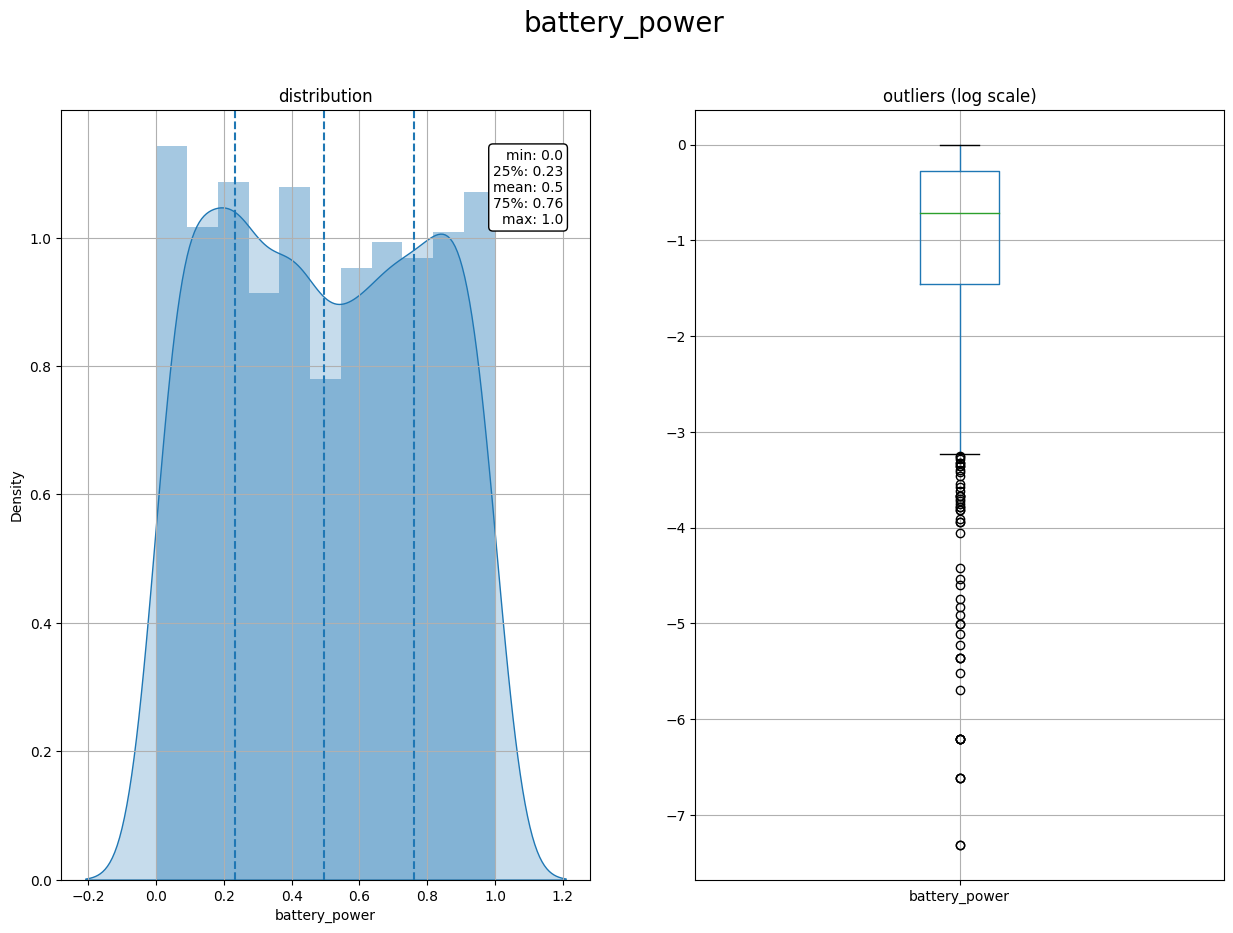

In [ ]:
show_dist('battery_power', train_x_scaled) #используем ранее созданную нами функцию для отрисовки графиков

In [ ]:
# Смотрим, что лежит в X, который результат нормировки train_x
X

array([[0.84101536, 0.        , 0.56      , ..., 1.        , 1.        ,
        0.        ],
       [0.81629927, 1.        , 0.2       , ..., 1.        , 1.        ,
        1.        ],
       [0.91716767, 1.        , 0.88      , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.91048764, 0.        , 0.36      , ..., 1.        , 1.        ,
        1.        ],
       [0.25250501, 1.        , 0.8       , ..., 1.        , 0.        ,
        1.        ],
       [0.20507682, 0.        , 0.72      , ..., 0.        , 1.        ,
        1.        ]])

In [ ]:
# смотрим какие индексы (по-сути номера объектов в основном датасете) остались в трейне
train_x.index

Index([ 773,  333,  380,  401,  167, 1007, 1490, 1651,  365, 1073,
       ...
         34, 1171, 1759, 1210, 1817,  149, 1806,  368,   93, 1108],
      dtype='int64', length=1400)

In [ ]:
X = scaler.fit_transform(test_x)

test_x_scaled = pd.DataFrame(X, columns=test_x.columns,index=test_x.index)
test_y_scaled = test_y

Text(0.5, 1.0, 'pearson correlation')

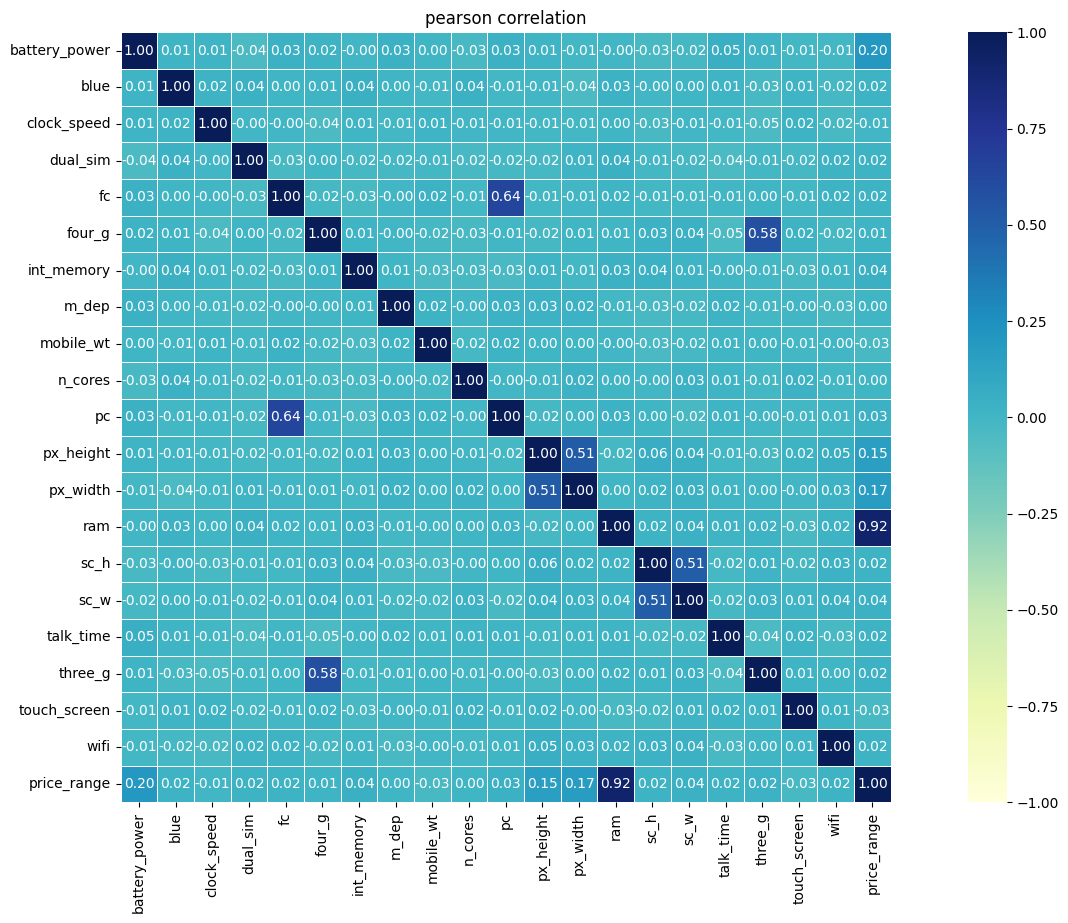

In [ ]:
# Вычислим матрицу корреляции, чтобы увидеть, какие параметры коррелируют друг с другом и целевой переменной:
corr_matrix = dtf.copy()
plt.figure(figsize=(20,10),dpi=100)

for col in corr_matrix.columns: #зададим условия для столбцо
    if corr_matrix[col].dtype == "O":
            corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson",numeric_only = True)

sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, square=True)
plt.title("pearson correlation")

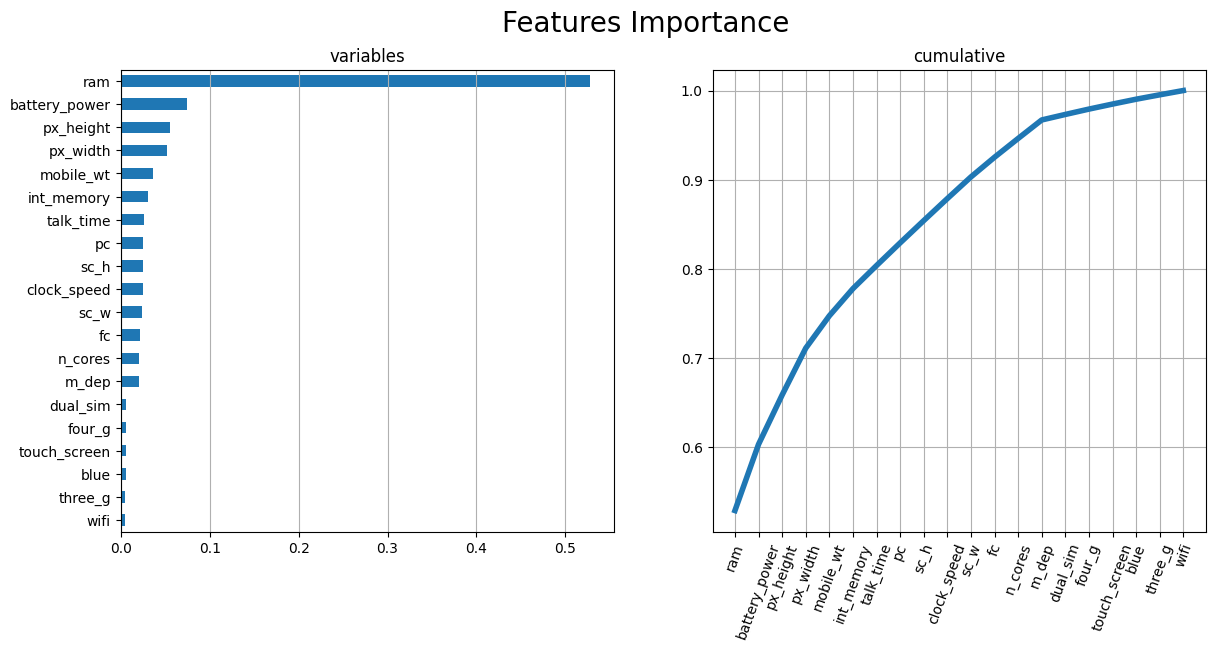

In [ ]:
# Оцениваем важность каждой фичи c помощью RandomForestClassifier
X = train_x_scaled.values
y = train_y_scaled.values
feature_names = train_x_scaled.columns.tolist()# имена столбцов в data.
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ #это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(14,6),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')# подпишем график
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')# подпишем график
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')#Настроим линии сетки.
plt.show()

In [ ]:
# Проектирование, обучение, тестирование и оценка модели машинного обучения:
X_train = train_x_scaled
y_train = train_y_scaled

X_test = test_x_scaled
y_test = test_y_scaled

In [ ]:
model = ensemble.GradientBoostingClassifier()
param_dic = {'learning_rate':[0.15,0.1,0.05],   # весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500],      # количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5],             # максимальная глубина дерева
             'min_samples_split':[2,4,6],       # задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5],        # минимальное количество выборок для формирования листа
             'max_features':[2,3,4],            # квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}       # образцы, которые будут использоваться для подгонки индивидуального базового файла

# random search(Рандомизированный поиск по гиперпараметрам.)
random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=10,
                                                   scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_   # здесь теперь хранятся параметры, при которых были получены наилучшие метрики на трейне

Best Model parameters: {'subsample': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 4, 'max_depth': 3, 'learning_rate': 0.05}
Best Model mean accuracy: 0.877142857142857


In [ ]:
model.fit(X_train, y_train)
predicted_prob = model.predict_proba(X_test) #прогнозирование
predicted = model.predict(X_test).astype('int32')

In [ ]:
# получили для каждого объекта - вектор вероятностей отнесения этого объекта к классам species
predicted_prob

array([[9.96662143e-01, 3.19699705e-03, 8.25869785e-05, 5.82733231e-05],
       [9.57740715e-01, 4.05312536e-02, 7.83212264e-04, 9.44818857e-04],
       [1.75197112e-01, 8.22771325e-01, 1.97213898e-03, 5.94240541e-05],
       ...,
       [1.59590856e-03, 5.76629148e-01, 4.20535157e-01, 1.23978609e-03],
       [2.05538713e-04, 6.79593421e-04, 1.97252577e-01, 8.01862291e-01],
       [6.12434909e-04, 1.90453946e-03, 3.62778231e-01, 6.34704795e-01]])

In [ ]:
# а это истинное значение, кто к какому классу относится
y_test.astype('int32')

,price_range
163,0
1750,0
1741,0
1641,2
1128,0
...,...
153,2
1440,3
1657,1
197,3


In [ ]:
## Accuray e AUC
# Теперь смотрим метрики. НА ТЕСТОВОМ ДАТАСЕТЕ
accuracy = metrics.accuracy_score(y_test, predicted) #Оценим точность классификации.
auc = metrics.roc_auc_score(y_test, predicted_prob,  multi_class='ovo',average= "weighted") #возвращаем долю правильно классифицированных выборок.
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))

## Precision e Recall
recall = metrics.recall_score(y_test, predicted, average="weighted")
precision = metrics.precision_score(y_test, predicted, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.89
Auc: 0.98
Recall (all 1s predicted right): 0.89
Precision (confidence when predicting a 1): 0.89
Detail:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       154
           1       0.84      0.85      0.84       153
           2       0.83      0.84      0.84       148
           3       0.96      0.91      0.94       145

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



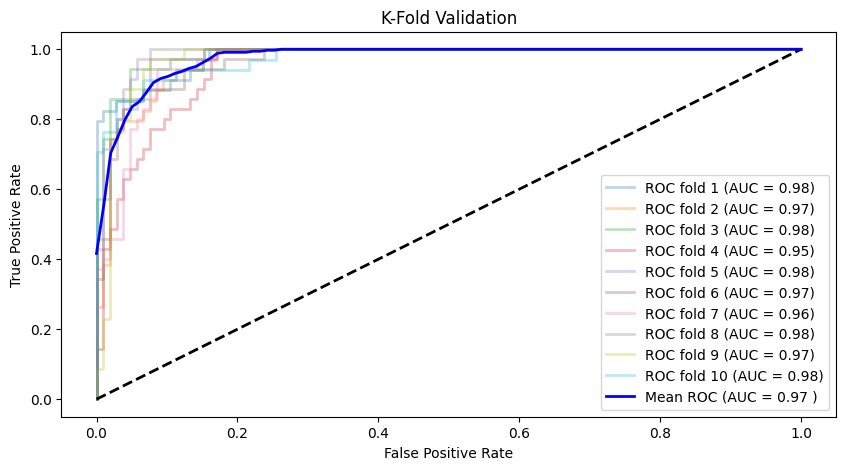

In [ ]:
# Строим ROC кривые
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train):
    X_train_selected = X_train.iloc[train]
    y_train_selected = y_train.iloc[train]
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = y_train.iloc[test]

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1

# Получим результат
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

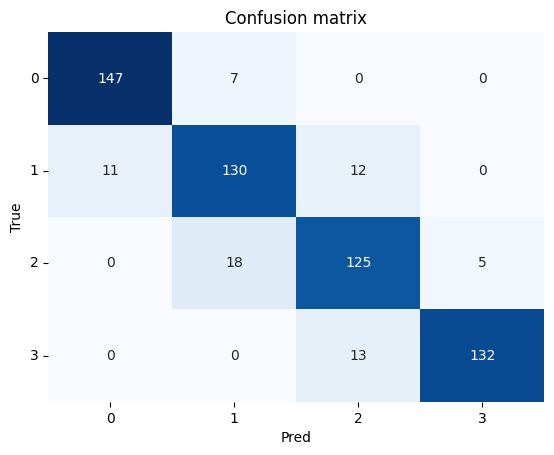

In [ ]:
# Confusion matrix (Мультиклассовый)
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

In [ ]:
# Вспомогательная функция для построения confusion matrix для каждого класса
def compute_class(ls_res, class_value): # возвращаем строку имен классов
    y_t_class = ls_res.copy().astype(int)
    y_t_class = y_t_class.apply(lambda c: 1 if c  == class_value  else 0)
    return  y_t_class

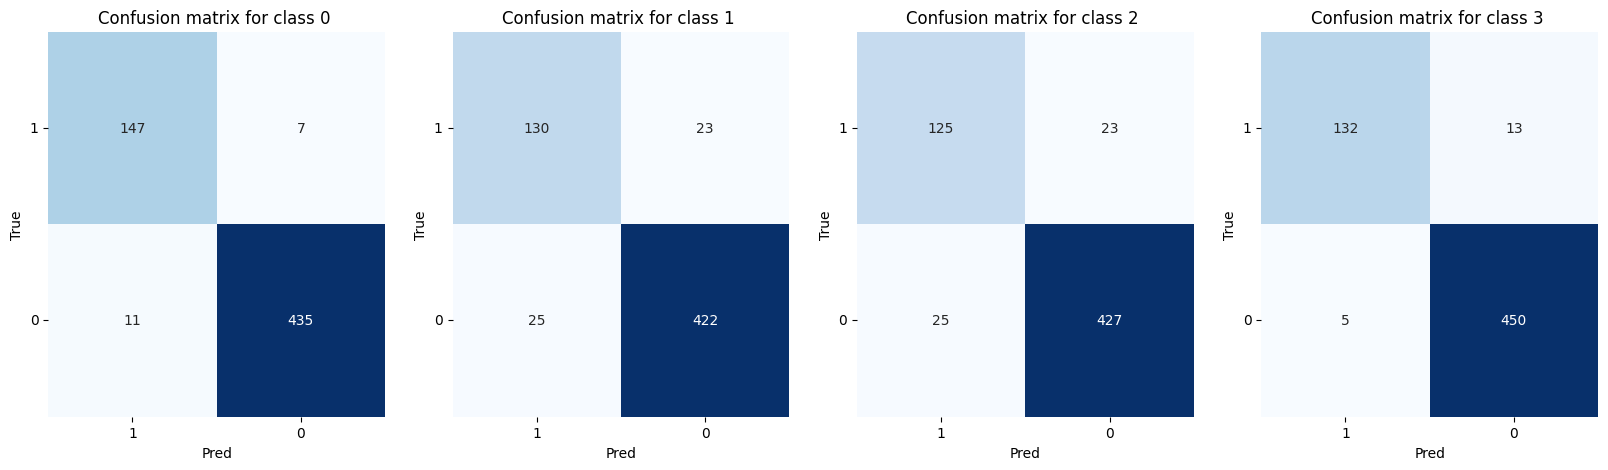

In [ ]:
# Confusion matrix (для каждого класса по отдельности)
classes = np.unique(y_test).astype(int)
lbs = [1,0]

fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(20,5),dpi=100)

for class_i in classes:
    y_one_class = compute_class(y_test,class_i)
    predicted_one_class = compute_class(pd.Series(predicted.tolist()),class_i)#возвращает строку имен классов
    cm = metrics.confusion_matrix(y_one_class, predicted_one_class, labels=lbs)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax[class_i])
    ax[class_i].set(xlabel="Pred", ylabel="True", title=f"Confusion matrix for class {class_i} ")
    ax[class_i].set_xticklabels(labels=lbs, rotation=0)
    ax[class_i].set_yticklabels(labels=lbs, rotation=0)
plt.show()

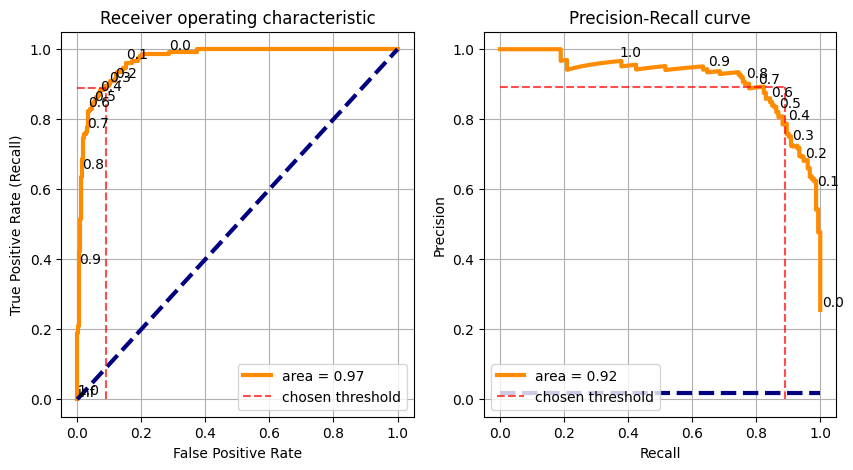

In [ ]:
# Еще ROC кривые
classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5),dpi=100)

# построим кривую ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

# найдем пороговые значения ROC
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next

#построим привую P-R
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob[:,1], pos_label=1)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)
## annotate P-R thresholds
# пороговые значения P-R

thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]),
                    xytext=(recalls[i],precisions[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
plt.show()

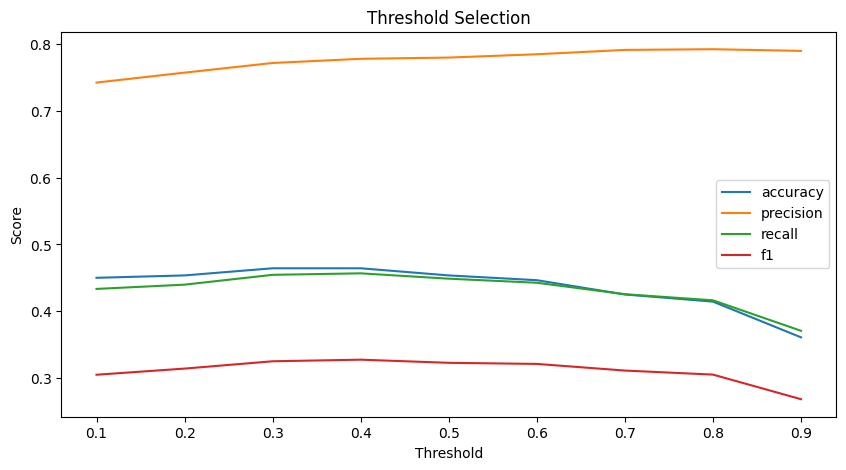

In [ ]:
# Определим, какие значения отсечки лучше всего для нашей модели.
# Для этого построим график ("значение отсечки", "значение метрики") для каждой метрики accuracy, precision, recall, f1

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='macro'))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='macro'))

# Добавим линии
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
dtf_scores.plot(ax=ax)
plt.show()